In [1]:
from tensorflow.keras.layers import Conv2D, Flatten ,Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib as plt
import numpy as np

import tensorflowjs as tfjs
import tensorflow as tf

In [2]:
img_height, img_width = (360, 360)
batch_size = 32

train_data_dir = r'C:/Users/Carlos/Desktop/wound/processed/train'
valid_data_dir = r'C:/Users/Carlos/Desktop/wound/processed/val'
test_data_dir = r'C:/Users/Carlos/Desktop/wound/processed/test'

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    # Data Augmentation
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.5,
    height_shift_range = 0.5,
    rotation_range = 30,
    channel_shift_range = 10,
    
    validation_split = 0.4) # 設定訓練及驗證資料比例

train_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size = (img_height, img_width), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    subset = 'training') # set as a training data

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir, 
    target_size = (img_height, img_width), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    subset = 'validation') # set as validation data

Found 49 images belonging to 6 classes.
Found 7 images belonging to 6 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size = (img_height, img_width), 
    batch_size = 1, 
    class_mode = 'categorical', 
    subset = 'validation') # set as validation data

Found 10 images belonging to 6 classes.


In [5]:
x,y = test_generator.next()
x.shape

(1, 360, 360, 3)

In [6]:
base_model = ResNet50(include_top = False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(train_generator.num_classes, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(train_generator, epochs = 10)

Epoch 1/10
2/2 [==============================] - 5s 2s/step - loss: 2.4316 - accuracy: 0.3265
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 3.0861 - accuracy: 0.5714
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 2.3860 - accuracy: 0.5714
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 1.2915 - accuracy: 0.6735
Epoch 5/10
2/2 [==============================] - 2s 1s/step - loss: 0.6556 - accuracy: 0.6939
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.7494 - accuracy: 0.7143
Epoch 7/10
2/2 [==============================] - 5s 2s/step - loss: 0.2852 - accuracy: 0.8776
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.3696 - accuracy: 0.8776
Epoch 9/10
2/2 [==============================] - 5s 3s/step - loss: 0.2894 - accuracy: 0.8776
Epoch 10/10
2/2 [==============================] - 2s 1s/step - loss: 0.2710 - accuracy: 0.9388


In [9]:
model.save('C:/Users/Carlos/Desktop/wound/model/models1102.h5')

In [8]:
tfjs.converters.save_keras_model(model, 'C:/Users/Carlos/Desktop/wound/model/models1102')

In [10]:
test_loss, test_acc = model.evaluate(test_generator, verbose = 2)
print('\nTset accuracy:', test_acc)

10/10 - 2s - loss: 0.5260 - accuracy: 0.7000

Tset accuracy: 0.699999988079071


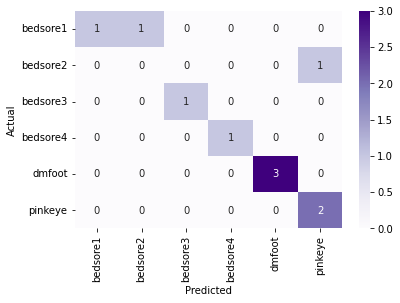

test accuracy : 80.0


In [13]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('C:/Users/Carlos/Desktop/wound/model/models1102.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns = ['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames = ['Actual'], colnames = ['Predicted'])

sn.heatmap(confusion_matrix, cmap = 'Purples', annot = True, fmt = 'd')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))